# Logistic Regression


In [104]:
import numpy as np
class logistic_regression:
    def __init__(self):
        self.weights = None
        self.learning_rate = 0.0001
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y, epochs=10000):
        # adding a column of ones to the input matrix
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.zeros(X.shape[1])
        
        for _ in range(epochs):
            y_pred = self.sigmoid(np.dot(X, self.weights))
            gradient = np.dot(X.T, (y - y_pred))
            self.weights += self.learning_rate * gradient
            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = self.sigmoid(np.dot(X, self.weights))
        return np.round(y_pred)
    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = self.sigmoid(np.dot(X, self.weights))
        return y_pred

# Data Preprocessing

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# DATASET 1

In [106]:
# preprocessing of a dataset




df=pd.read_csv("data1.csv")
df=df.drop(columns=["customerID"],axis=1)
df.drop_duplicates(inplace=True)
features = df.drop(["Churn"], axis=1)
target = df["Churn"]

# null values
features.isnull().sum()
# duplicate values
features.duplicated().sum()
# replacing space in float type columns
features["TotalCharges"]=features["TotalCharges"].replace(" ",np.nan)

# features.isnull().sum()
features["TotalCharges"]=features["TotalCharges"].astype(float)
features.fillna(features["TotalCharges"].mean(),inplace=True)
# Label Encoding the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(target)
#  converting object datatype to category
categorical_columns=[]
for col in features.columns:
    if features[col].dtype == 'object':
        categorical_columns.append(col)

# converting object datatype to category
for col in categorical_columns:
    features[col] = features[col].astype('category')

filter_col=list(features.select_dtypes(exclude=['category']).columns)

# one_hot encoding
features = pd.get_dummies(features)

# scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in filter_col:
    features[col] = scaler.fit_transform(features[[col]])

# features.head(10)

# target.shape

# Bagging
# ## Importing Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# ## Splitting the data, 80% for training and 20% for testing, among the training data, 80% for training and 20% for validation
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_val.shape

(1124, 45)

# DATA FILE 2

In [107]:
# # Defining column names
# import pandas as pd 
# import numpy as np
# columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# # Reading the train and test datasets
# adult_train = pd.read_csv("adult.data", names=columns, skipinitialspace=True)
# adult_test = pd.read_csv("adult.test", names=columns, skiprows=1, skipinitialspace=True)
# print(adult_train.shape, adult_test.shape)
# # Now combining the train and test data
# adult = pd.concat([adult_train, adult_test], axis=0)


# # replacing the '?' with np.nan
# adult.replace('?', np.nan, inplace=True)

# # income column has a period at the end for some instances, removing it
# adult['income'] = adult['income'].apply(lambda x: x.replace(".", ""))
# # converting the income column to binary
# adult['income'] = adult['income'].map({'<=50K': 0, '>50K': 1})

# # replacing null values with the mode
# for col in adult.columns:
#     adult[col].fillna(adult[col].mode()[0], inplace=True)
    
# # dropping duplicate values
# adult.drop_duplicates(inplace=True)

# features = adult.drop(["income"], axis=1)
# target = adult["income"]

# # converting object datatype to category
# categorical_columns = []
# for col in features.columns:
#     if features[col].dtype == 'object':
#         categorical_columns.append(col)
    
# for col in categorical_columns:
#     features[col] = features[col].astype('category')
    
# # one-hot encoding
# features = pd.get_dummies(features)

# # scaling the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# filter_col = list(features.select_dtypes(exclude=['category']).columns)
# for col in filter_col:
#     features[col] = scaler.fit_transform(features[[col]])

# # splitting the data
# # if index is greater than 32561, then it is from the test data
# features = pd.DataFrame(features)
# target = pd.Series(target)
# x_train = features.iloc[:32561]
# y_train = target.iloc[:32561]
# x_test = features.iloc[32561:]
# y_test = target.iloc[32561:]

# # now creating validation data from the training data, 80% for training and 20% for validation
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# DATASET 3


In [108]:

# credit_data = pd.read_csv("creditcard.csv")
# credit_data.drop_duplicates(inplace=True)
# # keeping all the positive class instances and randomly selecting 20000 negative class instances
# positive_class = credit_data[credit_data["Class"] == 1]
# negative_class = credit_data[credit_data["Class"] == 0]
# negative_class = resample(negative_class, n_samples=20000, random_state=42)
# credit_data = pd.concat([positive_class, negative_class], axis=0)

# credit_data.drop_duplicates(inplace=True)
# features = credit_data.drop(["Class"], axis=1)
# target = credit_data["Class"]

# # scaling the data
# scaler = StandardScaler()
# features = scaler.fit_transform(features)

# # splitting the data
# x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [109]:

features = pd.DataFrame(features)  
target = pd.Series(target)         


models=[]
accuracies=[]

for i in range(9):
    indices = resample(range(len(x_train)), replace=True, n_samples=int(0.8 * len(x_train)))
    

    sampled_features = features.iloc[indices]
    sampled_target = target.iloc[indices]


    model = logistic_regression()
    model.fit(x_train, y_train)
    models.append(model)

    y_pred = model.predict(x_test)
    accuracies.append(accuracy_score(y_test, y_pred))




# Stacking

In [110]:
# running the model on validation data, then adding those data as features to the validation data,so that we can train the meta model on it
val_features = []

for model in models:
    val_features.append(model.predict(x_val))
val_features = np.array(val_features).T

# now adding the features to the validation data
# x_val = np.concatenate((x_val, val_features), axis=1)
xx_val =np.concatenate((x_val, val_features), axis=1)

# training the meta model
meta_model = logistic_regression()
# meta_model.fit(x_val, y_val)
meta_model.fit(xx_val, y_val)

# running the model on the test data
test_features = []
for model in models:
    test_features.append(model.predict(x_test))
test_features = np.array(test_features).T

# now adding the features to the test data
# x_test = np.concatenate((x_test, test_features), axis=1)
xx_test = np.concatenate((x_test, test_features), axis=1)

# testing the meta model
# y_pred = meta_model.predict(x_test)
y_pred = meta_model.predict(xx_test)
accuracy_score(y_test, y_pred)

0.7914590747330961

# Performance on Test Data

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import numpy as np

# Function to compute all performance metrics
def evaluate_performance(y_true, y_pred, average="binary"):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precision
    precision = precision_score(y_true, y_pred, average=average)
    
    # Sensitivity (Recall)
    sensitivity = recall_score(y_true, y_pred, average=average)
    
    # F1-Score
    f1 = f1_score(y_true, y_pred, average=average)
    
    # AUROC
    try:
        auroc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auroc = None  # Handle cases where AUROC cannot be calculated
    
    # AUPR (Average Precision)
    aupr = average_precision_score(y_true, y_pred)
    
    # Confusion Matrix to calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auroc:
        print(f"AUROC: {auroc:.4f}")
    print(f"AUPR: {aupr:.4f}")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1": f1,
        "auroc": auroc,
        "aupr": aupr
    }

metrics = evaluate_performance(y_test, y_pred)



Accuracy: 0.7915
Precision: 0.5845
Sensitivity (Recall): 0.5795
Specificity: 0.8623
F1-Score: 0.5820
AUROC: 0.7209
AUPR: 0.4441


In [112]:
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score

# Collecting predictions from the 9 base models
all_predictions = []

for model in models:
    y_pred = model.predict(x_test)  
    all_predictions.append(y_pred)
    
# Transposing the predictions to get predictions for each instance
all_predictions = np.array(all_predictions).T  # Shape: (n_samples, 9)

# Performing majority voting (for classification)
y_pred_voting = stats.mode(all_predictions, axis=1)[0].flatten()

# Calculating accuracy for the voting ensemble
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print("Voting Ensemble Accuracy: ", voting_accuracy)
metrics_voting = evaluate_performance(y_test, y_pred_voting)


Voting Ensemble Accuracy:  0.795017793594306
Accuracy: 0.7950
Precision: 0.6026
Sensitivity (Recall): 0.5341
Specificity: 0.8822
F1-Score: 0.5663
AUROC: 0.7082
AUPR: 0.4385


In [113]:
import numpy as np
from sklearn.metrics import accuracy_score

# Step 1: Collect predictions from the 9 base models on the test set
test_features = []

for model in models:
    y_pred = model.predict(x_test)  # Predict using each base model
    test_features.append(y_pred)
    
# Step 2: Transpose the predictions to get predictions for each instance
test_features = np.array(test_features).T  # Shape: (n_samples, 9)

# Step 3: Concatenate the original test features with the base models' predictions
x_test_extended = np.concatenate((x_test, test_features), axis=1)

# Step 4: Use the meta-model to predict the final output
y_pred_stacking = meta_model.predict(x_test_extended)  # Meta-model prediction

# Step 5: Calculate accuracy for the stacking ensemble
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("Stacking Ensemble Accuracy: ", stacking_accuracy)

# Step 6: Evaluate performance for stacking ensemble (optional metrics like precision, recall, etc.)
metrics_stacking = evaluate_performance(y_test, y_pred_stacking)


Stacking Ensemble Accuracy:  0.7914590747330961
Accuracy: 0.7915
Precision: 0.5845
Sensitivity (Recall): 0.5795
Specificity: 0.8623
F1-Score: 0.5820
AUROC: 0.7209
AUPR: 0.4441


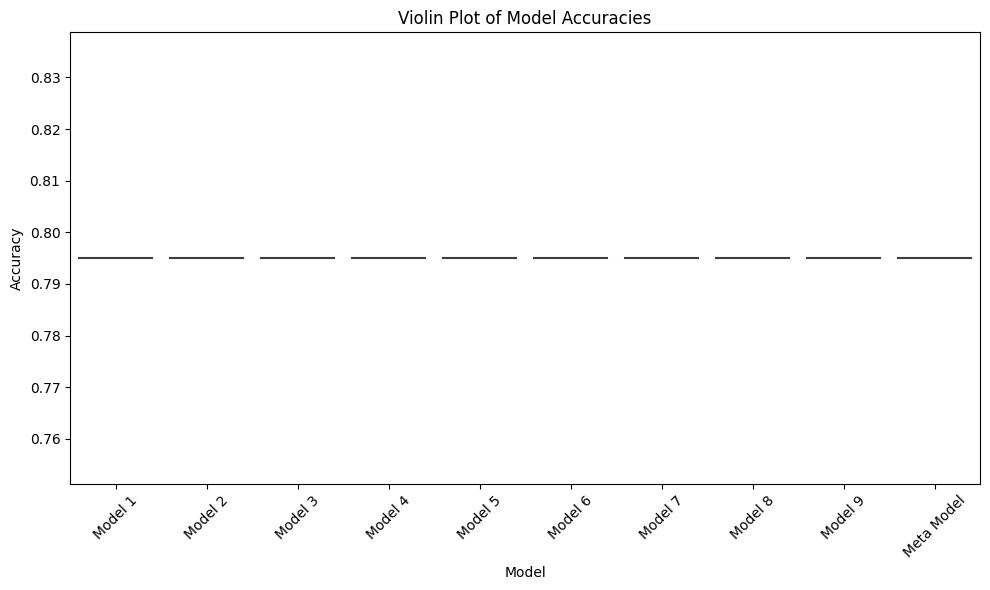

        Model  Accuracy  Precision  Sensitivity  Specificity  F1 Score  \
0     Model 1  0.795018   0.602564     0.534091     0.465909  0.566265   
1     Model 2  0.795018   0.602564     0.534091     0.465909  0.566265   
2     Model 3  0.795018   0.602564     0.534091     0.465909  0.566265   
3     Model 4  0.795018   0.602564     0.534091     0.465909  0.566265   
4     Model 5  0.795018   0.602564     0.534091     0.465909  0.566265   
5     Model 6  0.795018   0.602564     0.534091     0.465909  0.566265   
6     Model 7  0.795018   0.602564     0.534091     0.465909  0.566265   
7     Model 8  0.795018   0.602564     0.534091     0.465909  0.566265   
8     Model 9  0.795018   0.602564     0.534091     0.465909  0.566265   
9  Meta Model  0.795018   0.602564     0.534091     0.465909  0.566265   

      AUROC      AUPR  
0  0.844988  0.622678  
1  0.844988  0.622678  
2  0.844988  0.622678  
3  0.844988  0.622678  
4  0.844988  0.622678  
5  0.844988  0.622678  
6  0.844988  0.62

In [115]:
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Sensitivity': [],  # Recall
    'Specificity': [],
    'F1 Score': [],
    'AUROC': [],
    'AUPR': []
}

for i, model in enumerate(models):
    y_pred_base = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_base)
    precision = precision_score(y_test, y_pred_base)
    sensitivity = recall_score(y_test, y_pred_base)  # Recall is sensitivity
    specificity = recall_score(y_test, 1 - y_pred_base)  # Specificity calculation
    f1 = f1_score(y_test, y_pred_base)
    auroc = roc_auc_score(y_test, model.predict_proba(x_test))
    aupr = average_precision_score(y_test, model.predict_proba(x_test))

    metrics['Model'].append(f'Model {i+1}')
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Sensitivity'].append(sensitivity)
    metrics['Specificity'].append(specificity)
    metrics['F1 Score'].append(f1)
    metrics['AUROC'].append(auroc)
    metrics['AUPR'].append(aupr)

# Meta model metrics
meta_accuracy = accuracy_score(y_test, y_pred)
meta_precision = precision_score(y_test, y_pred)
meta_sensitivity = recall_score(y_test, y_pred)
meta_specificity = recall_score(y_test, 1 - y_pred)
meta_f1 = f1_score(y_test, y_pred)
meta_auroc = roc_auc_score(y_test, meta_model.predict_proba(xx_test))
meta_aupr = average_precision_score(y_test, meta_model.predict_proba(xx_test))

metrics['Model'].append('Meta Model')
metrics['Accuracy'].append(meta_accuracy)
metrics['Precision'].append(meta_precision)
metrics['Sensitivity'].append(meta_sensitivity)
metrics['Specificity'].append(meta_specificity)
metrics['F1 Score'].append(meta_f1)
metrics['AUROC'].append(meta_auroc)
metrics['AUPR'].append(meta_aupr)

# Create a DataFrame of metrics
metrics_df = pd.DataFrame(metrics)

# Violin Plot for Model Predictions
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Violin Plot of Model Accuracies')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Display the metrics DataFrame
print(metrics_df)